Problem : BUATLAH PREDIKSI EMPLOYEE RETENTION BERDASARKAN DATASET YANG DIBERIKAN (EMPLOYEE_RETENTION_DATA.CSV) DAN TEMUKAN APA YANG MENJADI PENYEBAB UTAMA KARYAWAN TETAP BERTAHAN DIPERUSAHAAN TERSEBUT.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib

In [2]:
data = pd.read_csv('employee_retention_data.csv')

# Exploratory Data Analysis (EDA)

In [3]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


# Preprocessing Data

## Menangani Missing Value

In [6]:
data.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

 terdapat 2 fitur waktu yaitu join_date dan quit_date. Ditambahkan fitur baru bernama retention dengan nilai Stay dan Leave. Retention akan bernilai Stay jika baris di fitur quit_date tidak ada isi yang artinya karyawan masih bertahan.

In [7]:
# Menambahkan kolom 'retention'
data['retention'] = data['quit_date'].apply(lambda x: 'Stay' if pd.isna(x) else 'Leave')
data

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,retention
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,Leave
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,Leave
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,Stay
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,Leave
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,Leave
...,...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaN,Stay
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaN,Stay
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,Leave
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,Leave


Menghapus fitur join_date dan quite_date karena informsi dari 2 fitur tersebut tidak diperlukan

In [8]:
column_drop = ['join_date', 'quit_date']
data = data.drop(column_drop, axis=1)

In [9]:
data.head()

,employee_id,company_id,dept,seniority,salary,retention
0,13021.0,7,customer_service,28,89000.0,Leave
1,825355.0,7,marketing,20,183000.0,Leave
2,927315.0,4,marketing,14,101000.0,Stay
3,662910.0,7,customer_service,20,115000.0,Leave
4,256971.0,2,data_science,23,276000.0,Leave


C:\Users\User\AppData\Local\Temp\ipykernel_1628\3711005054.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='retention', palette='Set2')


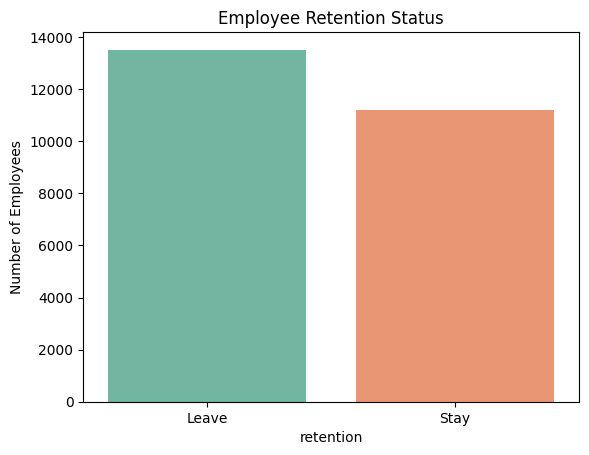

In [10]:
sns.countplot(data=data, x='retention', palette='Set2')
plt.title('Employee Retention Status')
plt.ylabel('Number of Employees')
plt.show()

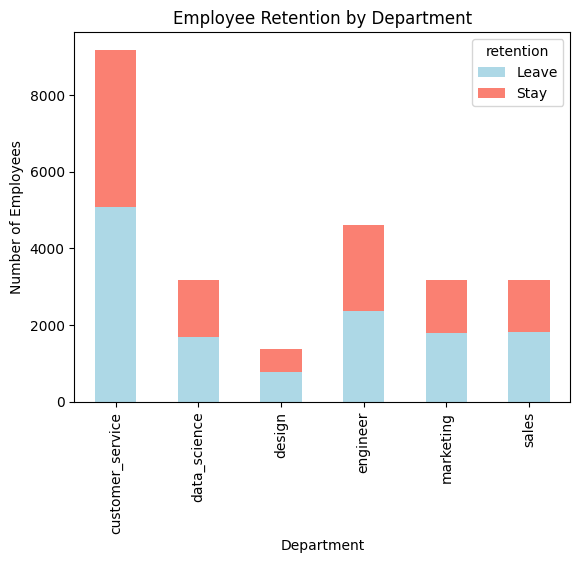

In [11]:
# Stacked Bar Chart
status_counts = data.groupby(['dept', 'retention']).size().unstack()
status_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'])
plt.title('Employee Retention by Department')
plt.ylabel('Number of Employees')
plt.xlabel('Department')
plt.show()


Berdasarkan grafik di setiap departemen karyawan cenderung meninggalkan perusahaan

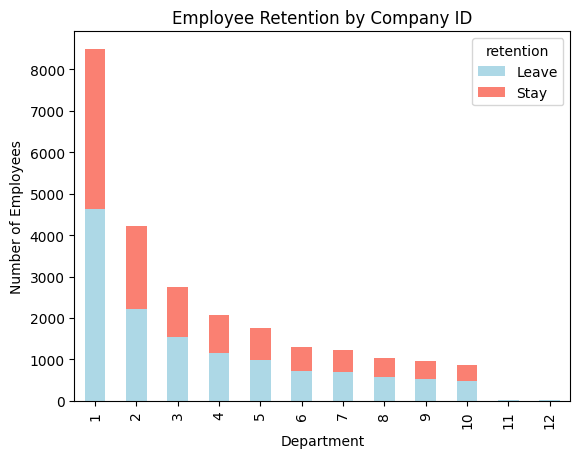

In [12]:
# Stacked Bar Chart
status_counts = data.groupby(['company_id', 'retention']).size().unstack()
status_counts.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'])
plt.title('Employee Retention by Company ID')
plt.ylabel('Number of Employees')
plt.xlabel('Department')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_1628\1660776339.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='retention', y='salary', palette='Set2')


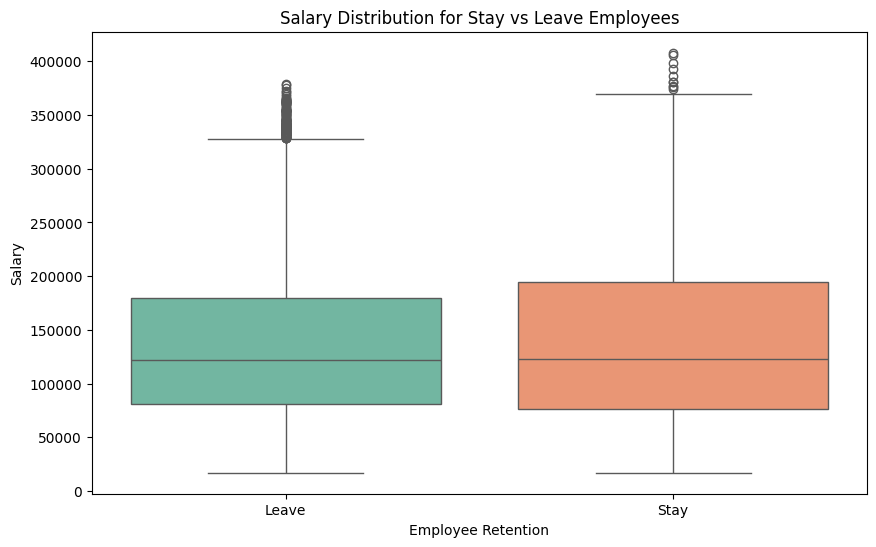

In [13]:
# Box Plot untuk Salary
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='retention', y='salary', palette='Set2')
plt.title('Salary Distribution for Stay vs Leave Employees')
plt.ylabel('Salary')
plt.xlabel('Employee Retention')
plt.show()


Dari grafik diatas dapat disimpulkan bahwa pegawai yang bertahan dan keluar mempunyai gaji rata-rata sama. tetapi karyawan yang bertahan cenderung memiliki salary yang lebih tinggi.

# Preprocessing Data

In [14]:
label_encoder = LabelEncoder()
data['dept'] = label_encoder.fit_transform(data['dept'])
scaler = StandardScaler()
data['salary'] = scaler.fit_transform(data[['salary']])
data['retention'] = data['retention'].map({'Stay': 1, 'Leave': 0})
data

,employee_id,company_id,dept,seniority,salary,retention
0,13021.0,7,0,28,-0.646667,0
1,825355.0,7,4,20,0.589254,0
2,927315.0,4,4,14,-0.488890,1
3,662910.0,7,0,20,-0.304817,0
4,256971.0,2,1,23,1.812026,0
...,...,...,...,...,...,...
24697,549847.0,3,0,16,-0.541483,1
24698,590087.0,4,3,10,0.286847,1
24699,777612.0,4,0,11,-0.935925,0
24700,97289.0,10,3,98,1.680546,0


<Axes: >

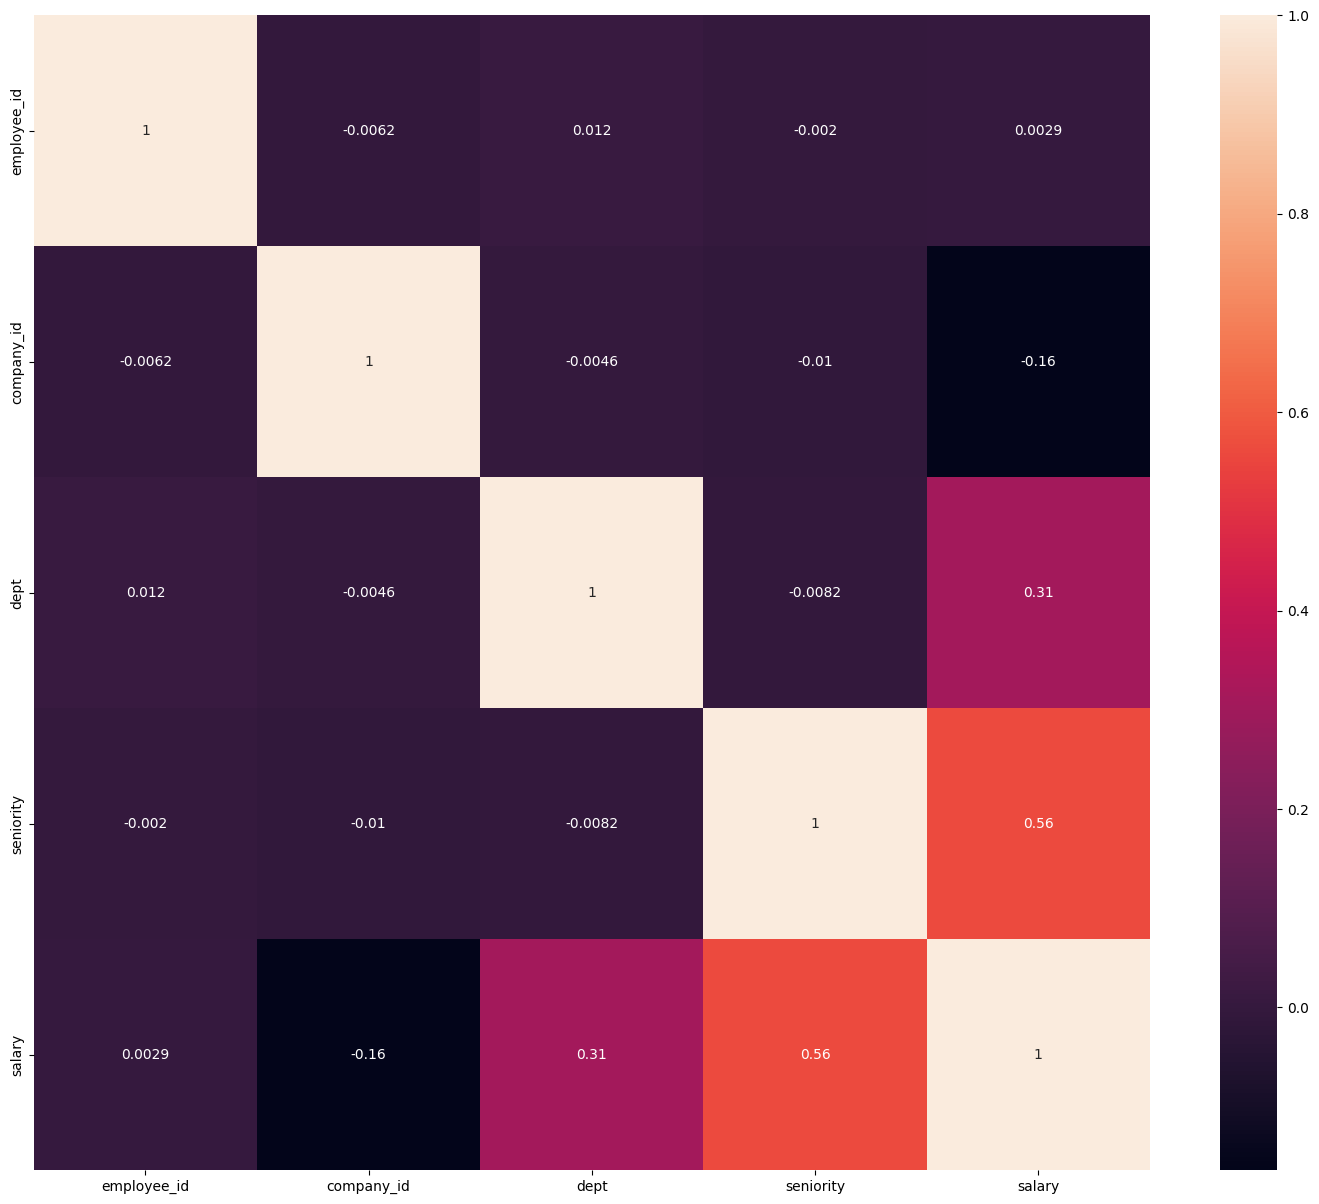

In [15]:
plt.figure(figsize=(18, 15))
sns.heatmap(data.drop(['retention'], axis=1).corr(),annot=True)

Berdasarka tabel diatas Retention berkorelasi cukup dengan fitur company_id, dept dan salary. sehingga fitur tersebut akan digunakan untuk pemodelan

# Modelling

In [16]:
select_feature = ['company_id', 'dept', 'salary']
X = data[select_feature]
y = data.retention

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Evaluation

In [19]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.63      4089
           1       0.48      0.32      0.38      3322

    accuracy                           0.54      7411
   macro avg       0.52      0.52      0.51      7411
weighted avg       0.53      0.54      0.52      7411



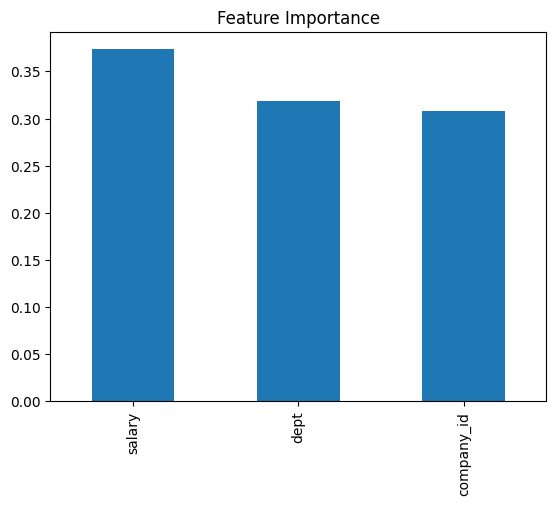

In [20]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.show()


PENYEBAB UTAMA KARYAWAN TETAP BERTAHAN DIPERUSAHAAN  Berdasarkan Grafik diatas adalah Salary

# Save Model

In [21]:
joblib.dump(model, 'model/model.joblib')
joblib.dump(label_encoder, 'model/encoder.joblib')
joblib.dump(scaler, 'model/scaler.joblib')

['model/scaler.joblib']

# Testing Model

In [22]:
data_test = pd.read_csv('employee_retention_data.csv').iloc[[2]].drop(['employee_id', 'seniority', 'join_date', 'quit_date'], axis=1)
data_test[['dept']] = label_encoder.transform(data_test[['dept']])
data_test[['salary']] = scaler.transform(data_test[['salary']])
data_test

c:\Users\User\anaconda3\envs\cv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,company_id,dept,salary
2,4,4,-0.48889


In [23]:
retention_value = model.predict(data_test)
if retention_value==1:
    retention = 'Stay'
else:
    retention = 'Leave'
retention

'Leave'